<a href="https://colab.research.google.com/github/100rab-S/Tensorflow-Developer-Certificate/blob/main/S%2BP_Week_3_Lesson_2_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<a href="https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%204%20-%20S%2BP/S%2BP%20Week%203%20Lesson%202%20-%20RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.4.1


In [2]:
def plot_series(time, series, format="-", start=0, end=None):  #creating synthetic data for modelling
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000                                      #splitting the series into train and validation for modelling
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20                 #no. of consecutive values taken from the series to predict the next value in the series
batch_size = 32                  #no. of windows taken at a time (to spped up training and procesesing)
shuffle_buffer_size = 1000       #it is used to shuffle with better efficiency and fast

In [3]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    ''' This function is used to create dataset which can directly be fed into the model.
        Parameters:
            series: the synthetic series that we generated in the above code (simply a time varied series of numbers),
            window_size: the number of consecutive values taken from the sereies as x for the model,
            batch_size: the number of windows that will be considered at once,
            shuffle_buffer: parameter for shuffle function to shuffle the data more efficiently
        Return:
            the function returns a list of tuple, where each tuple is a single training example in the form of ([x], y).
            where [x] is the window of dataset and y is the label.
    '''
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [4]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
#   ''' 
#       since the RNN layer need 3 dimensional input, but the windowed_dataset just created 2 dimensional dataset (ie ([x], y)), therefore we
#       need to add an extra dimension to the dataset. To do this preprocessing before feeding into the model, we can use Lambda layer
#       of keras api. Now in this layer, we add an extra dimension at the last of every training example. Now the dimension is ([x], y, 1),
#       where 1 denotes the univariate or multivariate feature of the series.
#       input_shape = [None] is because, so that the layer can take all kind of input.
#   '''
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
#   '''
#   it is a simple rnn layer which has 40 units and therefore it will provide 40 outputs to the next layer because we have set
#   return_sequences = True. if this was set to false (which is default) then the rnn layer would output just one output. But since the
#   next layer is also rnn layer, therefore we can set return_sequences = True and now this layer provides 40 outputs which gets feeded
#   into each unit of next rnn layer.
#   '''
  tf.keras.layers.SimpleRNN(40),
#   '''
#   this is another simple rnn layer, where each output from the previous layer is fed into each unit in this layer. that is the reason,
#   the number of units in this layer is equal to units in previous layer. The return_sequences is set to False in this layer because we
#   just need 1 output because next layer is a dense layer.
#   '''
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
#   '''
#   we again use lambda layer to do some arbitrary processing. Since in our dataset most of the values of x axis are in multiples of
#   100 therefore we multiply each value with 100 so that it can help training.
#   '''
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
# '''
# it is used to find a perfect learning rate for our optimizer by using multiple learning rate after each epoch.
# '''

optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
# '''
# loss = tf.keras.losses.Huber(), we use this loss function because it gives a nice output when the input might consist of outliers.
# '''

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule], verbose = 0)

(1e-08, 0.0001, 0.0, 30.0)

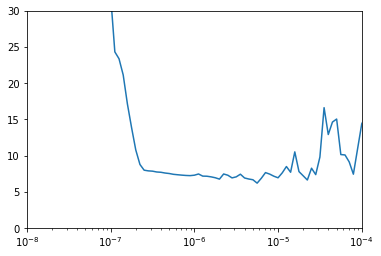

In [5]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

optimizer = tf.keras.optimizers.SGD(lr=5e-5, momentum=0.9)
# from the above graph we found the best learning paramter for the optimizer. Hence we will be using it to fine tune it.

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=400)

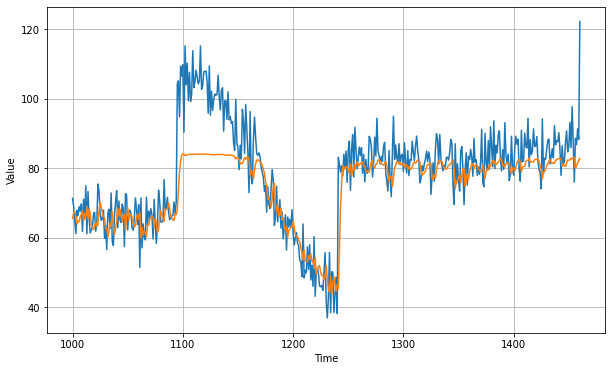

In [7]:
# now we will collect prediction on the validation datset. It can be done by passing the window from the validaiton set

forecast=[]
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis])) #instead of writing np.newaxis we can also write None.

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [8]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

6.582049

<Figure size 432x288 with 0 Axes>

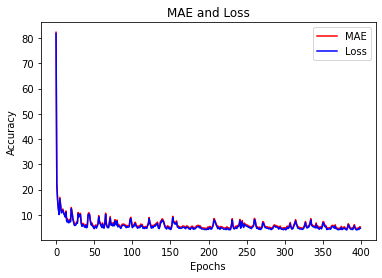

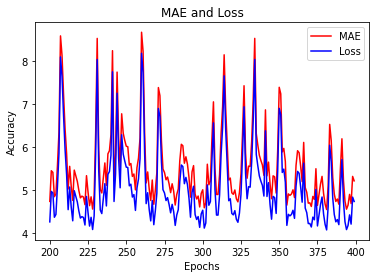

<Figure size 432x288 with 0 Axes>

In [9]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()